방문 주차에 따른 코호트를 생성하고, 코호트 별로 weekly 리텐션을 구하고 이를 heatmap으로 시각화

[참고 링크](https://www.youtube.com/watch?v=WWUG7T9ixTs)

In [3]:
# 전처리한 데이터 불러오기
import pandas as pd

df = pd.read_csv('C://Users//and_c//Desktop//sparta_ga4//train_df3.csv', low_memory = False)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 17 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   fullVisitorId              903653 non-null  object 
 1   channelGrouping            903653 non-null  object 
 2   visitStartTime             903653 non-null  int64  
 3   device_browser             903653 non-null  object 
 4   device_operatingSystem     903653 non-null  object 
 5   device_deviceCategory      903653 non-null  object 
 6   geoNetwork_continent       903653 non-null  object 
 7   geoNetwork_subContinent    903653 non-null  object 
 8   geoNetwork_country         903653 non-null  object 
 9   totals_visits              903653 non-null  int64  
 10  totals_hits                903653 non-null  int64  
 11  totals_bounces             903653 non-null  float64
 12  totals_newVisits           903653 non-null  float64
 13  totals_transactionRevenue  90

In [5]:
df.head()

,fullVisitorId,channelGrouping,visitStartTime,device_browser,device_operatingSystem,device_deviceCategory,geoNetwork_continent,geoNetwork_subContinent,geoNetwork_country,totals_visits,totals_hits,totals_bounces,totals_newVisits,totals_transactionRevenue,trafficSource_source,trafficSource_medium,trafficSource_campaign
0,1131660440785968503,Organic Search,1472830385,Chrome,Windows,desktop,Asia,Western Asia,Turkey,1,1,1.0,1.0,0.0,google,organic,(not set)
1,377306020877927890,Organic Search,1472880147,Firefox,Macintosh,desktop,Oceania,Australasia,Australia,1,1,1.0,1.0,0.0,google,organic,(not set)
2,3895546263509774583,Organic Search,1472865386,Chrome,Windows,desktop,Europe,Southern Europe,Spain,1,1,1.0,1.0,0.0,google,organic,(not set)
3,4763447161404445595,Organic Search,1472881213,UC Browser,Linux,desktop,Asia,Southeast Asia,Indonesia,1,1,1.0,1.0,0.0,google,organic,(not set)
4,27294437909732085,Organic Search,1472822600,Chrome,Android,mobile,Europe,Northern Europe,United Kingdom,1,1,1.0,0.0,0.0,google,organic,(not set)


In [6]:
# 데이터프레임에 한 열의 값을 바꾸기 위해서 def함수를 만들고 apply 적용
import pandas as pd
import datetime #날짜와 시간을 다루는 라이브러리
import pytz #다양한 시간대를 처리하기 위해 사용하는 라이브러리

# Posix 시간을 utc 시간으로 변환하는 함수
def posix_to_utc(visitStartTime):
    utc_time = datetime.datetime.utcfromtimestamp(visitStartTime)
    return utc_time

# Posix 시간을 UTC 지정한 로컬 시간대로 변환하는 함수
def posix_to_utc_local(visitStartTime):
    utc_time = datetime.datetime.utcfromtimestamp(visitStartTime) #posix -> utc시간대로
    local_timezone = pytz.timezone('America/New_York')  # 지역 시간대
    return utc_time.astimezone(local_timezone) # 그 지역 시간대로 변환

In [7]:
df['visitStartTime'] = df['visitStartTime'].apply(posix_to_utc)

In [8]:
# date 칼럼 추가하기
df['date'] = df['visitStartTime'].dt.date

In [9]:
# week기준으로 구분한 칼럼 추가
df['period_week'] = df['visitStartTime'].dt.to_period('W').apply(lambda x: x.start_time.strftime('%Y-%m-%d'))


In [10]:
# user의 첫 방문날짜 칼럼 추가
df['cohort_week'] = df.groupby('fullVisitorId')['period_week'].transform('min')

In [11]:
df[['period_week','cohort_week']].tail()

,period_week,cohort_week
903648,2017-01-02,2017-01-02
903649,2017-01-02,2017-01-02
903650,2017-01-02,2017-01-02
903651,2017-01-02,2017-01-02
903652,2017-01-02,2017-01-02


In [35]:
# Cohort_index 구하기 ...
df['cohort_index'] = (df['period_week'] - df['cohort_week'])/7

In [41]:
# df.groupby(['period_week','cohort_index'])['fullVisitorId'].nunique()
cohort_table = df.groupby(['period_week','cohort_index'])['fullVisitorId'].apply(pd.Series.nunique).reset_index()

In [43]:
# create Table
cohort_table_pivot = cohort_table.pivot(index = 'period_week', columns=['cohort_index'], values='fullVisitorId')
cohort_table_pivot

cohort_index,0 days,1 days,2 days,3 days,4 days,5 days,6 days,7 days,8 days,9 days,...,43 days,44 days,45 days,46 days,47 days,48 days,49 days,50 days,51 days,52 days
period_week,,,,,,,,,,,,,,,,,,,,,
2016-08-01,13476.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-08,14098.0,675.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-15,14004.0,583.0,443.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-22,13035.0,480.0,351.0,316.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-29,13922.0,381.0,296.0,258.0,279.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-05,12778.0,379.0,221.0,235.0,183.0,217.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-12,13140.0,369.0,230.0,181.0,202.0,166.0,198.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-19,13246.0,413.0,203.0,197.0,153.0,126.0,120.0,171.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-26,12826.0,418.0,231.0,149.0,150.0,93.0,85.0,93.0,140.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
div_cohort_pivot = cohort_table_pivot.divide(cohort_table_pivot.iloc[:,0],axis=0)

<AxesSubplot:xlabel='cohort_index', ylabel='period_week'>

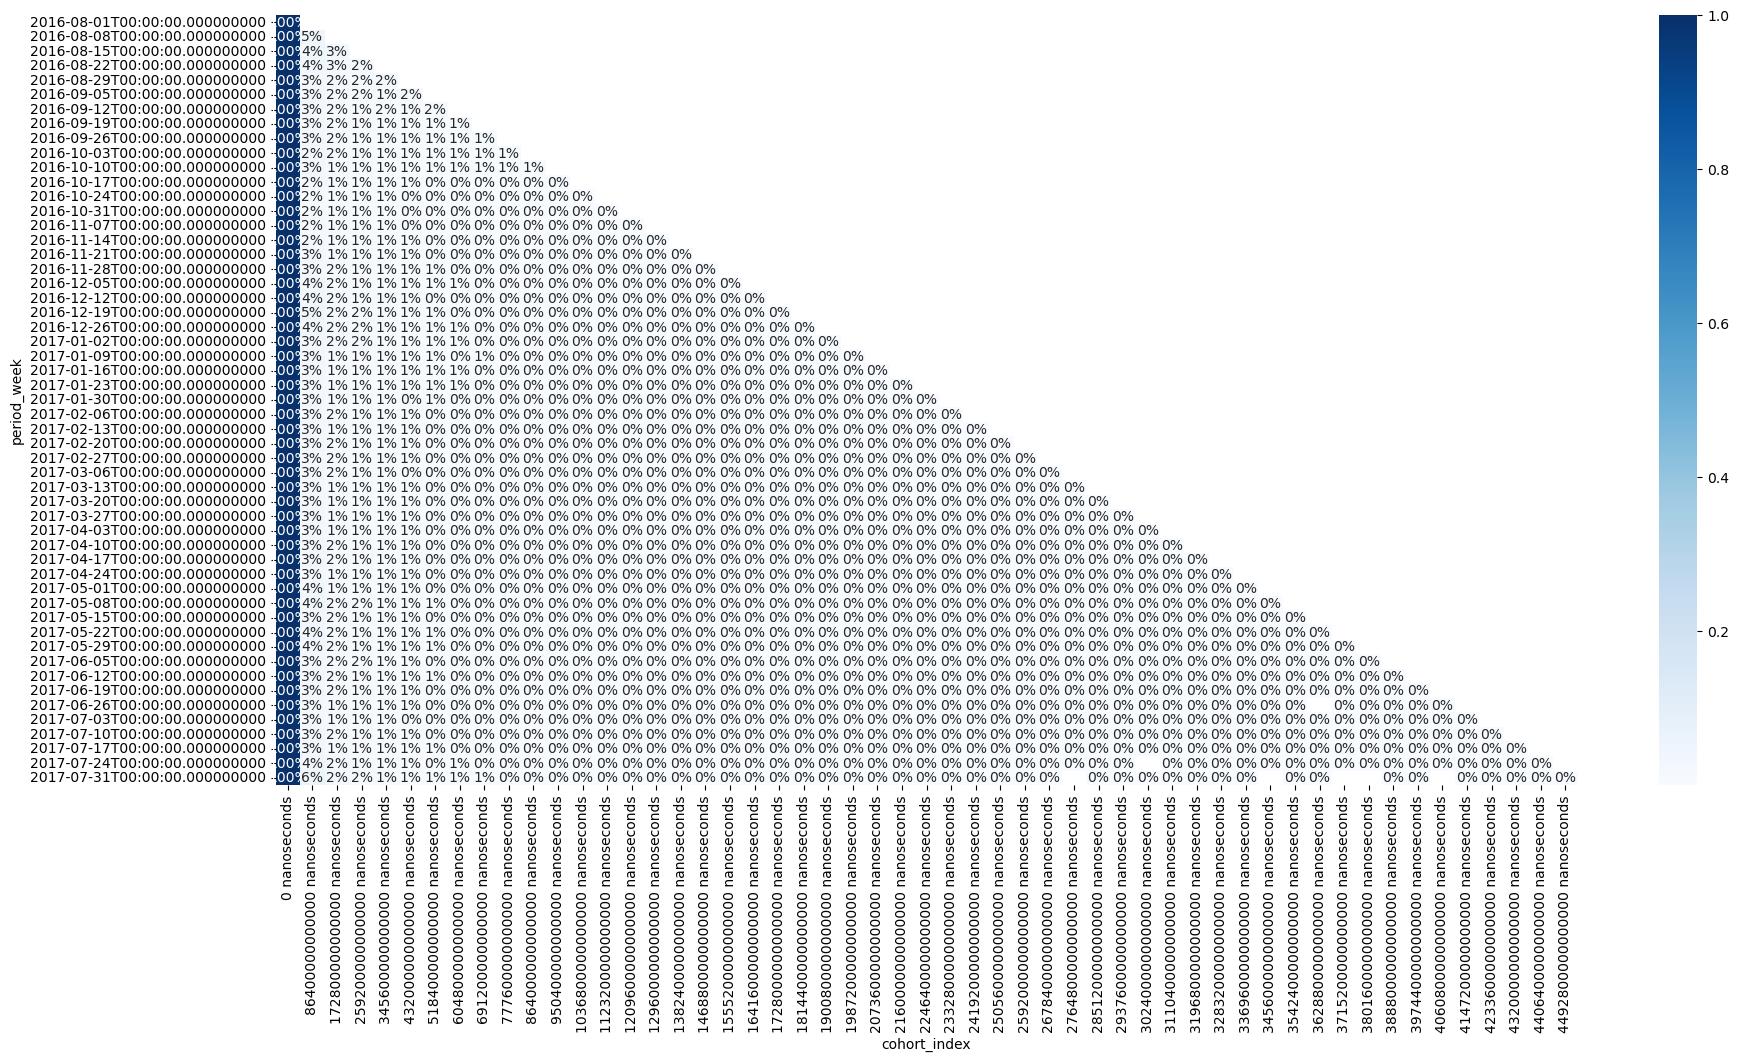

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(21,10))
sns.heatmap(div_cohort_pivot, annot = True, cmap='Blues',fmt = '.0%')

In [ ]:
# plt.rcParams['figure.figsize'] = [10,8]
# plt.pcolor(table)
# # 또는 sns.heatmap()
# # 피벗테이블의 df를 pandas를 이용해 표현도 가능 df.style.background_gradient
# plt.title('Weekly Retention', fontsize=20)
# plt.xlabel('week', fontsize=14)
# plt.ylabel('visit', fontsize=14)
# plt.colorbar()